
# Variational Inference: Bayesian Neural Networks

source: https://colab.research.google.com/github/pymc-devs/pymc-examples/blob/main/examples/variational_inference/bayesian_neural_network_advi.ipynb
    

## Current trends in Machine Learning

**Probabilistic Programming**, **Deep Learning** and "**Big Data**" are among the biggest topics in machine learning. Inside of PP, a lot of innovation is focused on making things scale using **Variational Inference**. In this example, I will show how to use **Variational Inference** in PyMC to fit a simple Bayesian Neural Network. I will also discuss how bridging Probabilistic Programming and Deep Learning can open up very interesting avenues to explore in future research.

### Probabilistic Programming at scale
**Probabilistic Programming** allows very flexible creation of custom probabilistic models and is mainly concerned with **inference** and learning from your data. The approach is inherently **Bayesian** so we can specify **priors** to inform and constrain our models and get uncertainty estimation in form of a **posterior** distribution. Using {ref}`MCMC sampling algorithms <multilevel_modeling>` we can draw samples from this posterior to very flexibly estimate these models. PyMC, [NumPyro](https://github.com/pyro-ppl/numpyro), and [Stan](http://mc-stan.org/) are the current state-of-the-art tools for consructing and estimating these models. One major drawback of sampling, however, is that it's often slow, especially for high-dimensional models and large datasets. That's why more recently, **variational inference** algorithms have been developed that are almost as flexible as MCMC but much faster. Instead of drawing samples from the posterior, these algorithms instead fit a distribution (*e.g.* normal) to the posterior turning a sampling problem into and optimization problem. Automatic Differentation Variational Inference {cite:p}`kucukelbir2015automatic` is implemented in several probabilistic programming packages including PyMC, NumPyro and Stan.

Unfortunately, when it comes to traditional ML problems like classification or (non-linear) regression, Probabilistic Programming often plays second fiddle (in terms of accuracy and scalability) to more algorithmic approaches like [ensemble learning](https://en.wikipedia.org/wiki/Ensemble_learning) (e.g. [random forests](https://en.wikipedia.org/wiki/Random_forest) or [gradient boosted regression trees](https://en.wikipedia.org/wiki/Boosting_(machine_learning)).

### Deep Learning

Now in its third renaissance, neural networks have been making headlines repeatedly by dominating almost any object recognition benchmark, kicking ass at Atari games {cite:p}`mnih2013playing`, and beating the world-champion Lee Sedol at Go {cite:p}`silver2016masteringgo`. From a statistical point, Neural Networks are extremely good non-linear function approximators and representation learners. While mostly known for classification, they have been extended to unsupervised learning with AutoEncoders {cite:p}`kingma2014autoencoding` and in all sorts of other interesting ways (e.g. [Recurrent Networks](https://en.wikipedia.org/wiki/Recurrent_neural_network), or [MDNs](http://cbonnett.github.io/MDN_EDWARD_KERAS_TF.html) to estimate multimodal distributions). Why do they work so well? No one really knows as the statistical properties are still not fully understood.

A large part of the innoviation in deep learning is the ability to train these extremely complex models. This rests on several pillars:
* Speed: facilitating the GPU allowed for much faster processing.
* Software: frameworks like [PyTorch](https://pytorch.org/) and [TensorFlow](https://www.tensorflow.org/) allow flexible creation of abstract models that can then be optimized and compiled to CPU or GPU.
* Learning algorithms: training on sub-sets of the data -- stochastic gradient descent -- allows us to train these models on massive amounts of data. Techniques like drop-out avoid overfitting.
* Architectural: A lot of innovation comes from changing the input layers, like for convolutional neural nets, or the output layers, like for [MDNs](http://cbonnett.github.io/MDN_EDWARD_KERAS_TF.html).

### Bridging Deep Learning and Probabilistic Programming
On one hand we have Probabilistic Programming which allows us to build rather small and focused models in a very principled and well-understood way to gain insight into our data; on the other hand we have deep learning which uses many heuristics to train huge and highly complex models that are amazing at prediction. Recent innovations in variational inference allow probabilistic programming to scale model complexity as well as data size. We are thus at the cusp of being able to combine these two approaches to hopefully unlock new innovations in Machine Learning. For more motivation, see also [Dustin Tran's](https://twitter.com/dustinvtran) [blog post](http://dustintran.com/blog/a-quick-update-edward-and-some-motivations/).

While this would allow Probabilistic Programming to be applied to a much wider set of interesting problems, I believe this bridging also holds great promise for innovations in Deep Learning. Some ideas are:
* **Uncertainty in predictions**: As we will see below, the Bayesian Neural Network informs us about the uncertainty in its predictions. I think uncertainty is an underappreciated concept in Machine Learning as it's clearly important for real-world applications. But it could also be useful in training. For example, we could train the model specifically on samples it is most uncertain about.
* **Uncertainty in representations**: We also get uncertainty estimates of our weights which could inform us about the stability of the learned representations of the network.
* **Regularization with priors**: Weights are often L2-regularized to avoid overfitting, this very naturally becomes a Gaussian prior for the weight coefficients. We could, however, imagine all kinds of other priors, like spike-and-slab to enforce sparsity (this would be more like using the L1-norm).
* **Transfer learning with informed priors**: If we wanted to train a network on a new object recognition data set, we could bootstrap the learning by placing informed priors centered around weights retrieved from other pre-trained networks, like GoogLeNet {cite:p}`szegedy2014going`.
* **Hierarchical Neural Networks**: A very powerful approach in Probabilistic Programming is hierarchical modeling that allows pooling of things that were learned on sub-groups to the overall population (see [Hierarchical Linear Regression in PyMC3](https://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/)). Applied to Neural Networks, in hierarchical data sets, we could train individual neural nets to specialize on sub-groups while still being informed about representations of the overall population. For example, imagine a network trained to classify car models from pictures of cars. We could train a hierarchical neural network where a sub-neural network is trained to tell apart models from only a single manufacturer. The intuition being that all cars from a certain manufactures share certain similarities so it would make sense to train individual networks that specialize on brands. However, due to the individual networks being connected at a higher layer, they would still share information with the other specialized sub-networks about features that are useful to all brands. Interestingly, different layers of the network could be informed by various levels of the hierarchy -- *e.g.* early layers that extract visual lines could be identical in all sub-networks while the higher-order representations would be different. The hierarchical model would learn all that from the data.
* **Other hybrid architectures**: We can more freely build all kinds of neural networks. For example, Bayesian non-parametrics could be used to flexibly adjust the size and shape of the hidden layers to optimally scale the network architecture to the problem at hand during training. Currently, this requires costly hyper-parameter optimization and a lot of tribal knowledge.

## Bayesian Neural Networks in PyMC

### Generating data

First, lets generate some toy data -- a simple binary classification problem that's not linearly separable.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import seaborn as sns

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [2]:
%config InlineBackend.figure_format = 'retina'
floatX = pytensor.config.floatX
RANDOM_SEED = 9927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

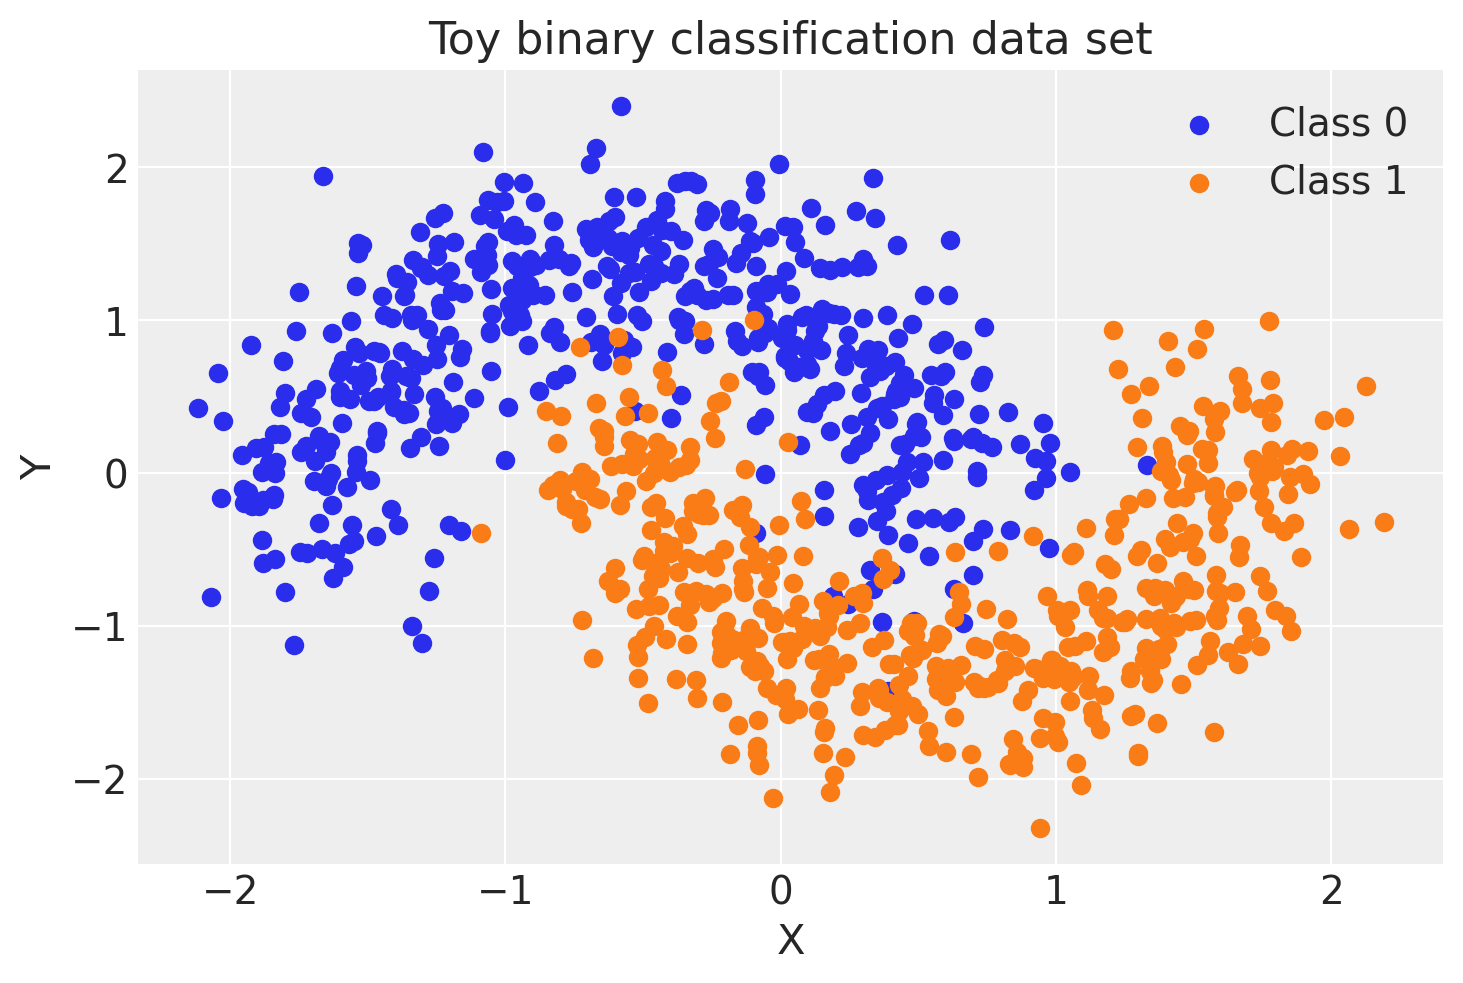

In [4]:
fig, ax = plt.subplots()
ax.scatter(X[Y == 0, 0], X[Y == 0, 1], color="C0", label="Class 0")
ax.scatter(X[Y == 1, 0], X[Y == 1, 1], color="C1", label="Class 1")
sns.despine()
ax.legend()
ax.set(xlabel="X", ylabel="Y", title="Toy binary classification data set");

### Model specification

A neural network is quite simple. The basic unit is a [perceptron](https://en.wikipedia.org/wiki/Perceptron) which is nothing more than [logistic regression](http://pymc-devs.github.io/pymc3/notebooks/posterior_predictive.html#Prediction). We use many of these in parallel and then stack them up to get hidden layers. Here we will use 2 hidden layers with 5 neurons each which is sufficient for such a simple problem.

In [5]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = rng.standard_normal(size=(X_train.shape[1], n_hidden)).astype(floatX)
    init_2 = rng.standard_normal(size=(n_hidden, n_hidden)).astype(floatX)
    init_out = rng.standard_normal(size=n_hidden).astype(floatX)

    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "train_cols": np.arange(X_train.shape[1]),
        # "obs_id": np.arange(X_train.shape[0]),
    }
    with pm.Model(coords=coords) as neural_network:
        ann_input = pm.Data("ann_input", X_train, mutable=True, dims=("obs_id", "train_cols"))
        ann_output = pm.Data("ann_output", Y_train, mutable=True, dims="obs_id")

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal(
            "w_in_1", 0, sigma=1, initval=init_1, dims=("train_cols", "hidden_layer_1")
        )

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal(
            "w_1_2", 0, sigma=1, initval=init_2, dims=("hidden_layer_1", "hidden_layer_2")
        )

        # Weights from hidden layer to output
        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, initval=init_out, dims="hidden_layer_2")

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli(
            "out",
            act_out,
            observed=ann_output,
            total_size=Y_train.shape[0],  # IMPORTANT for minibatches
            dims="obs_id",
        )
    return neural_network


neural_network = construct_nn(X_train, Y_train)

That's not so bad. The `Normal` priors help regularize the weights. Usually we would add a constant `b` to the inputs but I omitted it here to keep the code cleaner.

### Variational Inference: Scaling model complexity

We could now just run a MCMC sampler like {class}`pymc.NUTS` which works pretty well in this case, but was already mentioned, this will become very slow as we scale our model up to deeper architectures with more layers.

Instead, we will use the {class}`pymc.ADVI` variational inference algorithm. This is much faster and will scale better. Note, that this is a mean-field approximation so we ignore correlations in the posterior.

In [6]:
%%time

with neural_network:
    approx = pm.fit(n=30_000)

/Users/porterjenkins/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


Finished [100%]: Average Loss = 127.12


CPU times: user 14.1 s, sys: 3.14 s, total: 17.2 s
Wall time: 1min 46s


Plotting the objective function (ELBO) we can see that the optimization iteratively improves the fit.

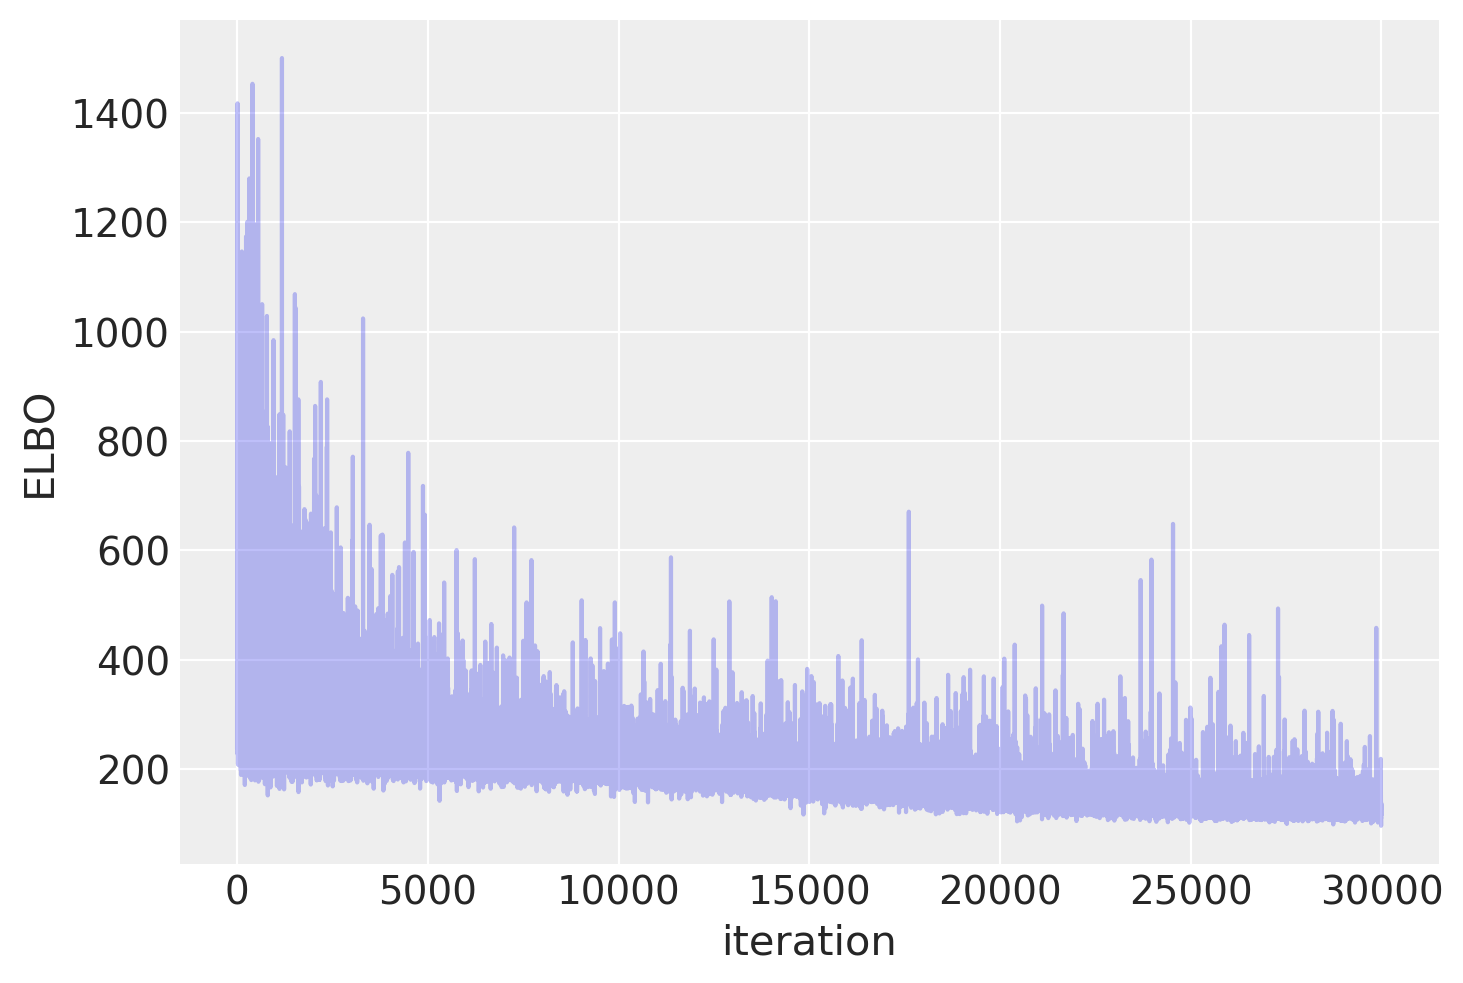

In [7]:
plt.plot(approx.hist, alpha=0.3)
plt.ylabel("ELBO")
plt.xlabel("iteration");

In [8]:
trace = approx.sample(draws=5000)

Now that we trained our model, lets predict on the hold-out set using a posterior predictive check (PPC). We can use {func}`~pymc.sample_posterior_predictive` to generate new data (in this case class predictions) from the posterior (sampled from the variational estimation).

In [9]:
with neural_network:
    pm.set_data(new_data={"ann_input": X_test})
    ppc = pm.sample_posterior_predictive(trace)
    trace.extend(ppc)

Sampling: [out]


We can average the predictions for each observation to estimate the underlying probability of class 1.

In [10]:
pred = ppc.posterior_predictive["out"].mean(("chain", "draw")) > 0.5

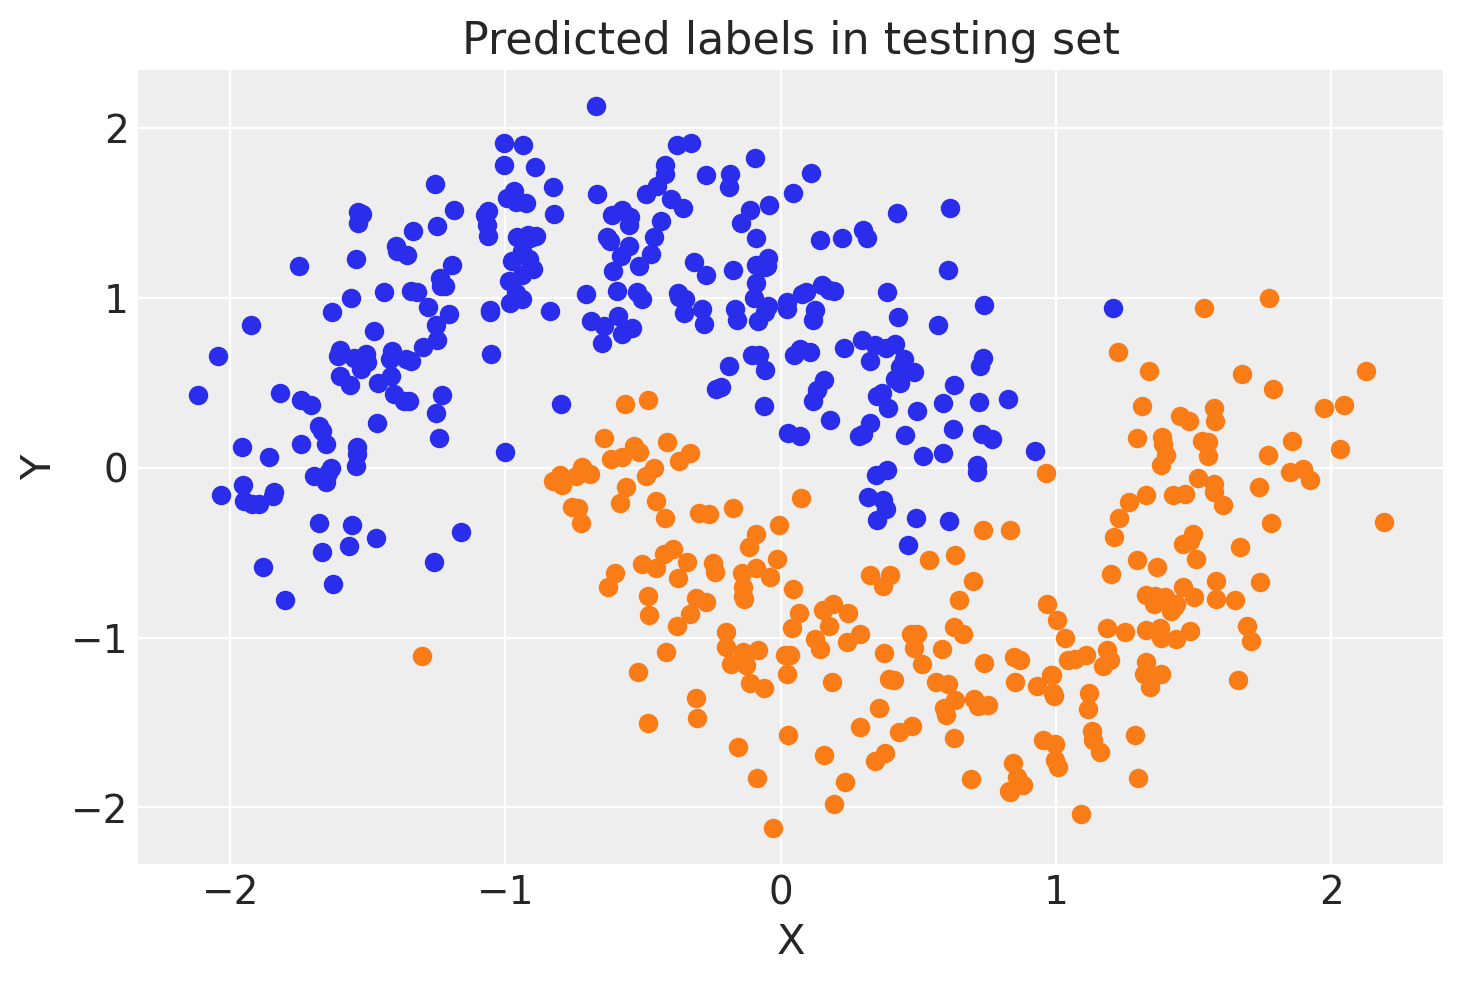

In [11]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1], color="C0")
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="C1")
sns.despine()
ax.set(title="Predicted labels in testing set", xlabel="X", ylabel="Y");

In [12]:
print(f"Accuracy = {(Y_test == pred.values).mean() * 100}%")

Accuracy = 96.0%


Hey, our neural network did all right!

## Lets look at what the classifier has learned

For this, we evaluate the class probability predictions on a grid over the whole input space.

In [13]:
grid = pm.floatX(np.mgrid[-3:3:100j, -3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [14]:
with neural_network:
    pm.set_data(new_data={"ann_input": grid_2d, "ann_output": dummy_out})
    ppc = pm.sample_posterior_predictive(trace)

/Users/porterjenkins/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/model.py:1846: ShapeWarning: You are resizing a variable with dimension 'obs_id' which was initialized as a mutable dimension by another variable ('ann_input'). Remember to update that variable with the correct shape to avoid shape issues.
  model.set_data(variable_name, new_value, coords=coords)
Sampling: [out]


In [15]:
y_pred = ppc.posterior_predictive["out"]

### Probability surface

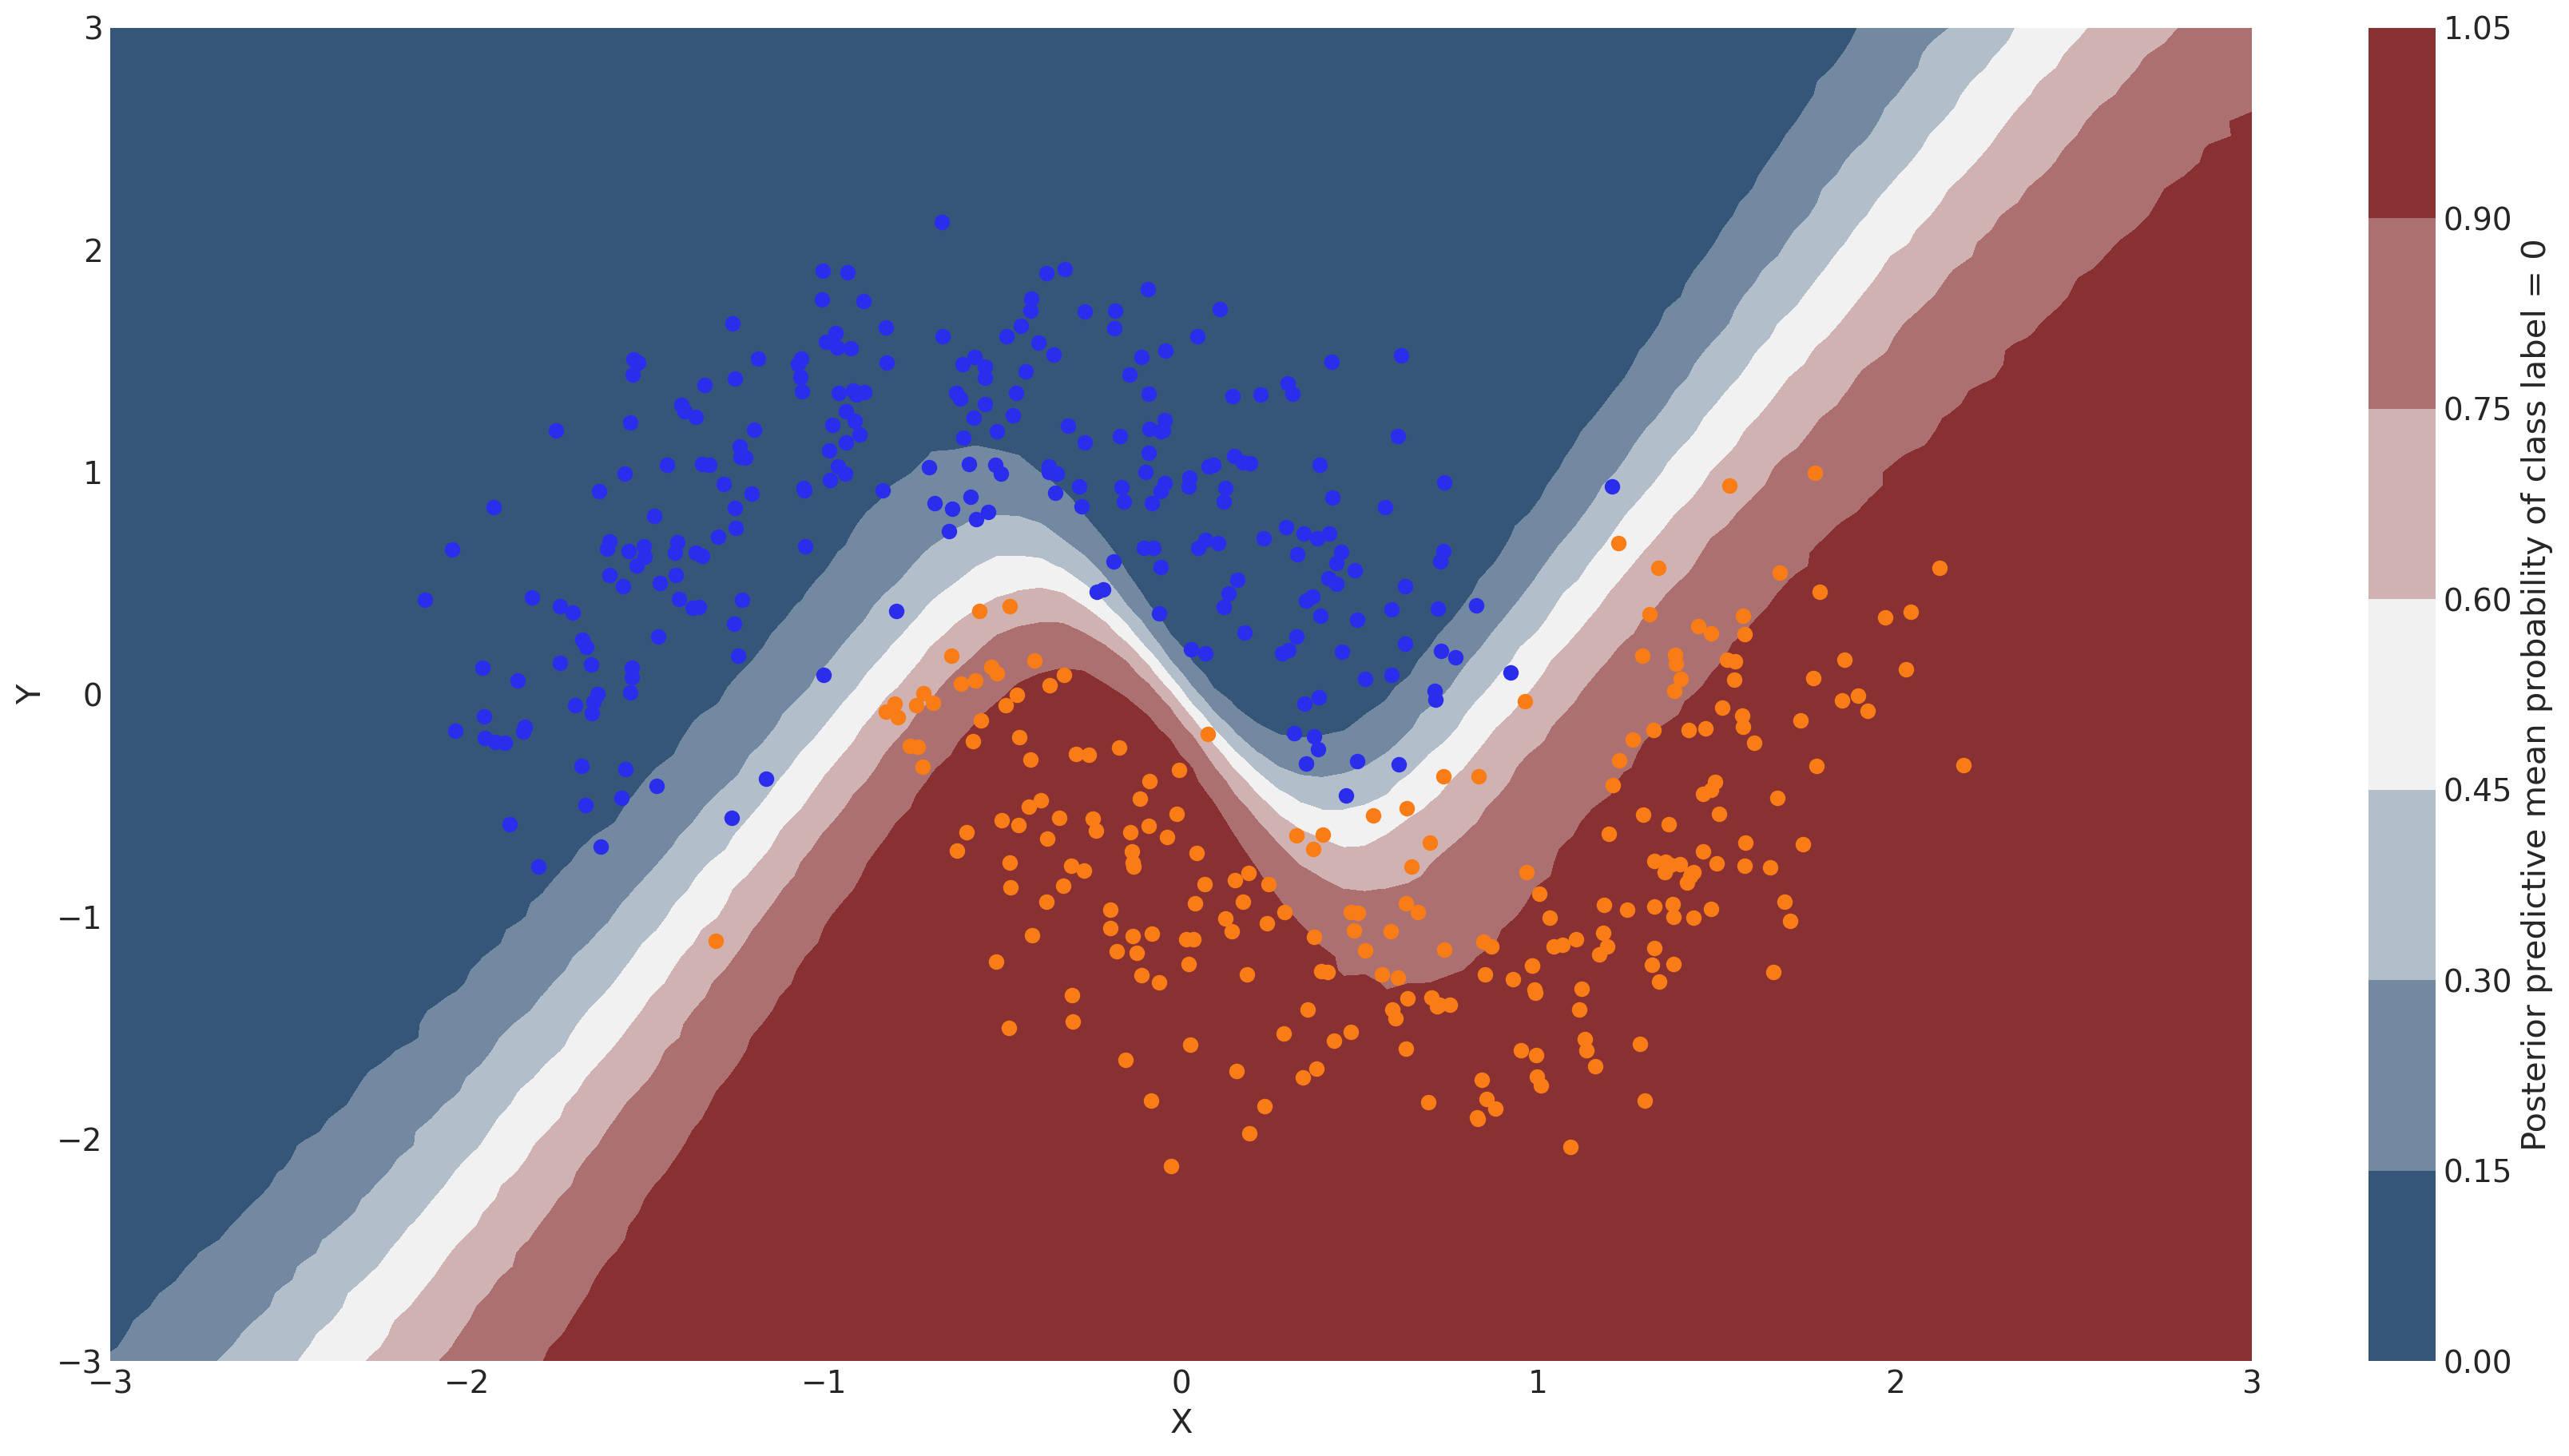

In [16]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(
    grid[0], grid[1], y_pred.mean(("chain", "draw")).values.reshape(100, 100), cmap=cmap
)
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1], color="C0")
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="C1")
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel="X", ylabel="Y")
cbar.ax.set_ylabel("Posterior predictive mean probability of class label = 0");

### Uncertainty in predicted value

Note that we could have done everything above with a non-Bayesian Neural Network. The mean of the posterior predictive for each class-label should be identical to maximum likelihood predicted values. However, we can also look at the standard deviation of the posterior predictive to get a sense for the uncertainty in our predictions. Here is what that looks like:

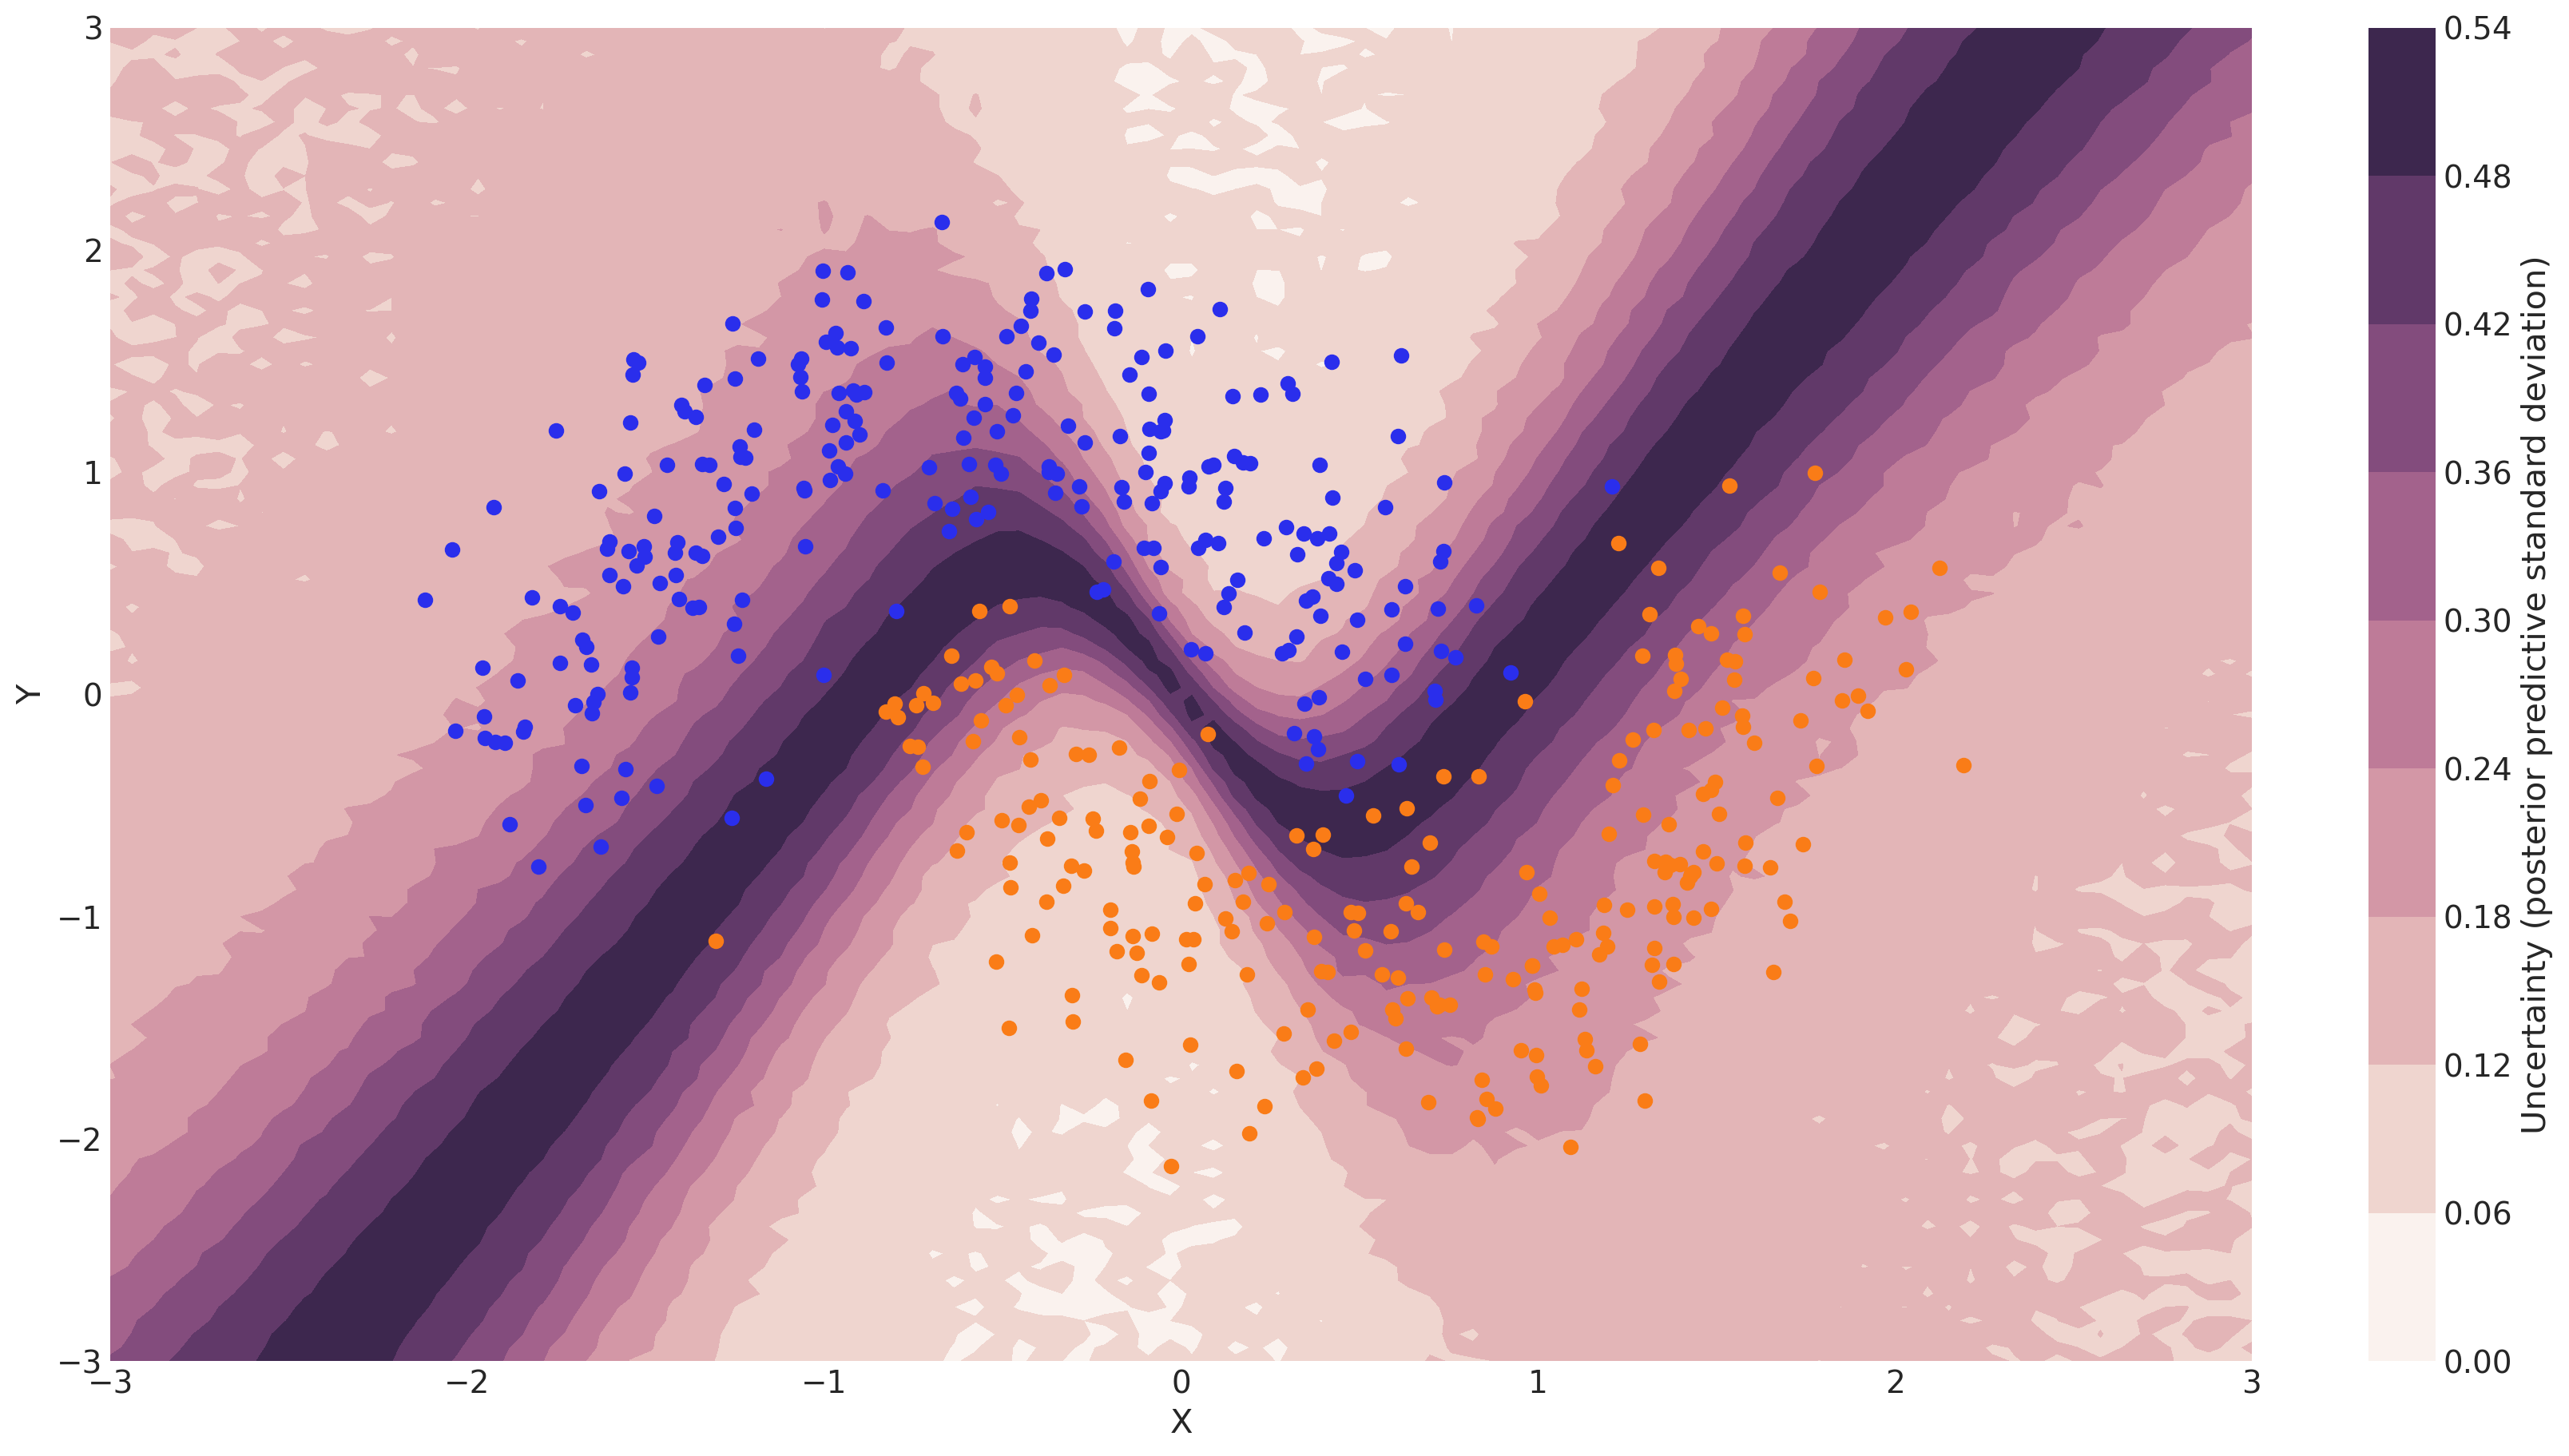

In [17]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(
    grid[0], grid[1], y_pred.squeeze().values.std(axis=0).reshape(100, 100), cmap=cmap
)
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1], color="C0")
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="C1")
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel="X", ylabel="Y")
cbar.ax.set_ylabel("Uncertainty (posterior predictive standard deviation)");

We can see that very close to the decision boundary, our uncertainty as to which label to predict is highest. You can imagine that associating predictions with uncertainty is a critical property for many applications like health care. To further maximize accuracy, we might want to train the model primarily on samples from that high-uncertainty region.

## Mini-batch ADVI

So far, we have trained our model on all data at once. Obviously this won't scale to something like ImageNet. Moreover, training on mini-batches of data (stochastic gradient descent) avoids local minima and can lead to faster convergence.

Fortunately, ADVI can be run on mini-batches as well. It just requires some setting up:

In [18]:
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)
neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    approx = pm.fit(40000, method=pm.ADVI())

Finished [100%]: Average Loss = 125.04


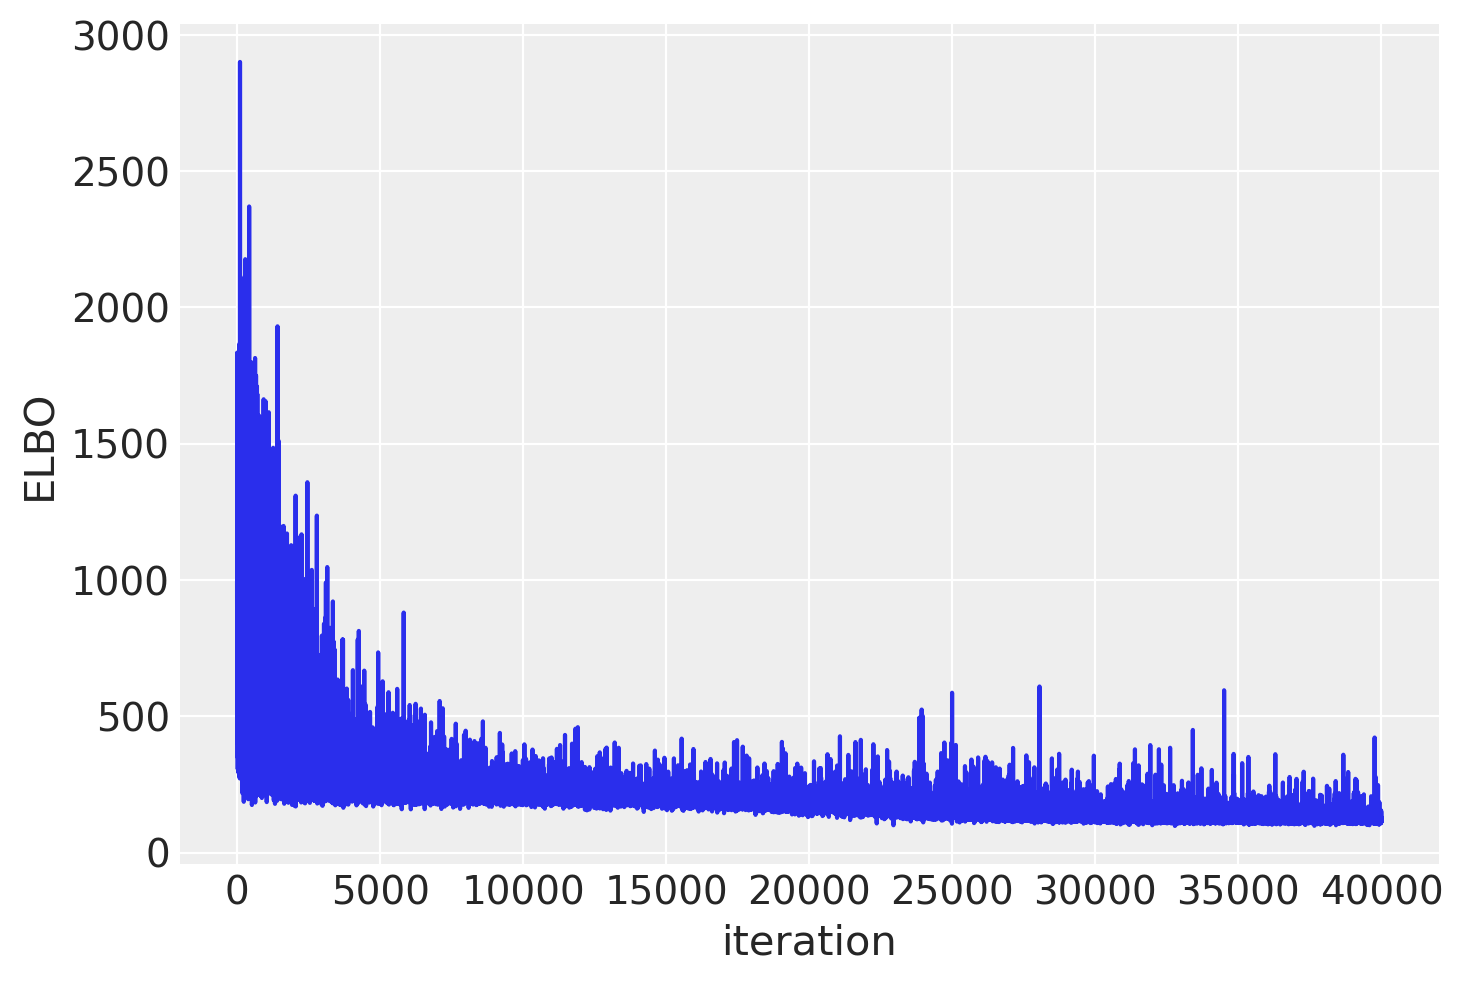

In [19]:
plt.plot(approx.hist)
plt.ylabel("ELBO")
plt.xlabel("iteration");

As you can see, mini-batch ADVI's running time is much lower. It also seems to converge faster.

For fun, we can also look at the trace. The point is that we also get uncertainty of our Neural Network weights.

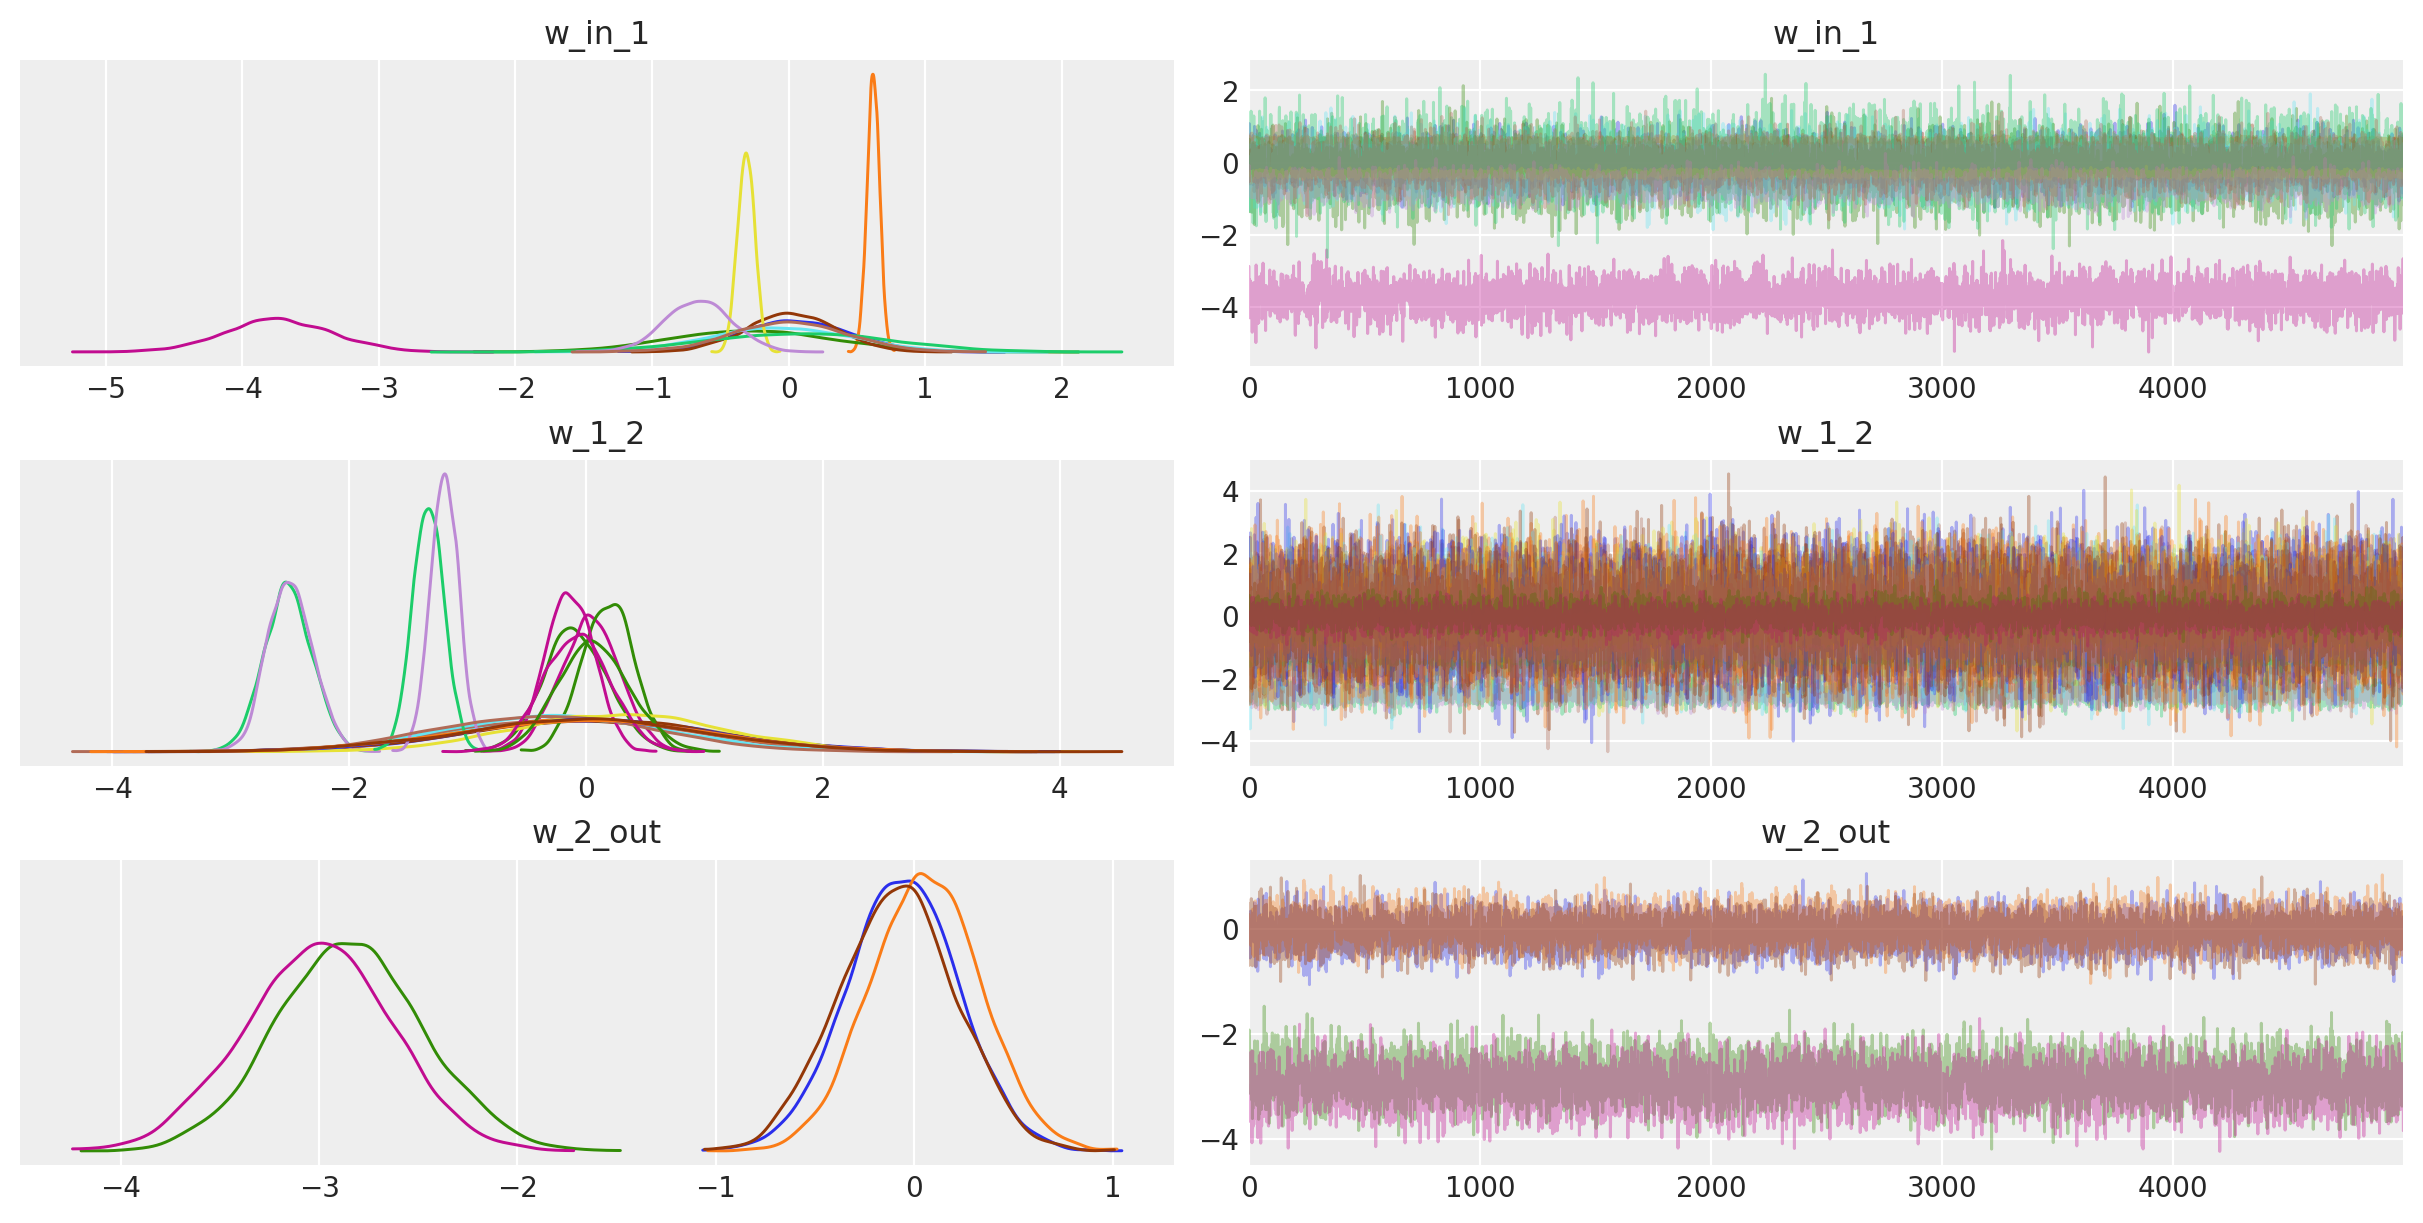

In [20]:
az.plot_trace(trace);

You might argue that the above network isn't really deep, but note that we could easily extend it to have more layers, including convolutional ones to train on more challenging data sets.

## Acknowledgements

[Taku Yoshioka](https://github.com/taku-y) did a lot of work on ADVI in PyMC3, including the mini-batch implementation as well as the sampling from the variational posterior. I'd also like to the thank the Stan guys (specifically Alp Kucukelbir and Daniel Lee) for deriving ADVI and teaching us about it. Thanks also to Chris Fonnesbeck, Andrew Campbell, Taku Yoshioka, and Peadar Coyle for useful comments on an earlier draft.